In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mode
import math
%matplotlib inline

In [2]:
matches = pd.read_csv('matches.csv')
delivery = pd.read_csv('deliveries.csv')

In [3]:
match_ids = matches[matches.season >= 2016]['id'].unique()
matches1 = matches[(matches.season >= 2016) & (matches['result']=='normal')]
matches1 = matches1.drop(['player_of_match','venue','umpire1','umpire2','umpire3', 'dl_applied', 'season', 'city', 'date', 'result'], axis=1)
matches1.dropna(inplace=True)

In [8]:
team_1 = 'Chennai Super Kings'
team_2 = 'Rajasthan Royals'

In [9]:
def team_correction(row):
    row = row.strip()
    if row == 'Delhi Daredevils':
        return 'Delhi Capitals'
    if row == 'Rising Pune Supergiants':
        return 'Rising Pune Supergiant'
    return row

for col in ['team1', 'team2', 'winner', 'toss_winner']:
    matches1[col] = matches1[col].apply(team_correction)
    

# Winning Probability of Teams

Text(0.5, 1.0, 'Percentage of Winning')

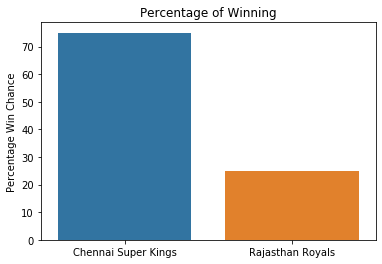

In [10]:
wins = pd.DataFrame(matches1[(matches1['team1'].isin([team_1, team_2])) & (matches1['team2'].isin([team_1, team_2]))]['winner'].value_counts())
wins['Percentage Win Chance'] = (wins['winner']/sum(wins['winner']))*100
sns.barplot(wins.index, y=wins['Percentage Win Chance'])
plt.title('Percentage of Winning')

In [11]:
delivery = delivery[delivery.match_id.apply(lambda x: True if x in match_ids else False)]
for col in ['batting_team', 'bowling_team']:
    delivery[col] = delivery[col].apply(team_correction)

delivery.fillna(0, inplace=True)
delivery['player_dismissed'] = delivery['player_dismissed'].apply(lambda x: 0 if x==0 else 1)

delivery['batsman_runs'] = delivery['batsman_runs'].apply(lambda x: x-1 if ((x==7) or (x==5)) else x)

# RR score in powerplay

The avearge of lowest 25% score and 50 - 75% scores is taken


Text(0, 0.5, 'Runs per powerplay')

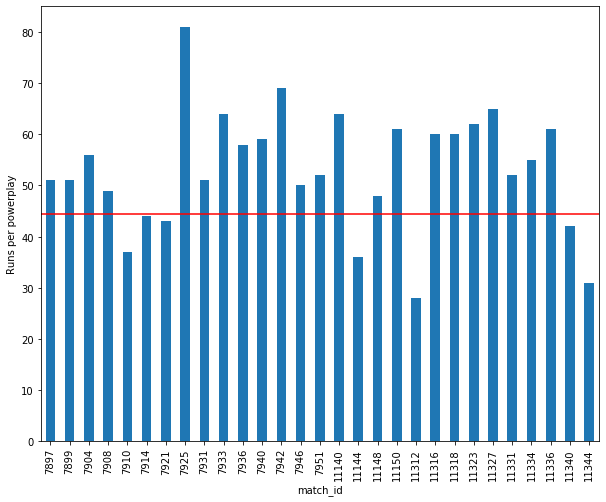

In [30]:
rr_pp = delivery[(delivery['batting_team']==team_2) & (delivery['over']<=6)].groupby('match_id').sum()
rr_pp['total_runs'].plot(kind='bar', figsize=(10,8))
plt.axhline(y=np.mean([rr_pp['total_runs'].describe()[3], rr_pp['total_runs'].describe()[6]]), color='red')
print("The avearge of lowest 25% score and 50 - 75% scores is taken")
plt.ylabel("Runs per powerplay")

# Deepak Chahar Economic Rate

In [55]:
econ_rate = list()
match_id_ = list()
for mat_id in delivery[delivery['bowler']=='DL Chahar']['match_id'].unique():
    balls = 0
    runs = 0
    for run in delivery[(delivery['bowler']=='DL Chahar') & (delivery['match_id']==mat_id)]['total_runs']:
        runs += run
        balls += 1
    if runs/(int(balls/6)) < 11:
        econ_rate.append(runs/(int(balls/6)))
        match_id_.append(mat_id)

In [58]:
chahar_ER = pd.DataFrame(index=match_id_, data=econ_rate)
print("Range of Predicted Economic Rate of DL Chahar: ", chahar_ER[0].mean()-0.2, "-", chahar_ER[0].mean()+0.2)

Range of Predicted Economic Rate of DL Chahar:  7.602777777777777 - 8.002777777777776


# Jofra Archer wickets in death overs

In [66]:
archer_wk = delivery[(delivery['bowler']=='J Archer') & (delivery['over']>=15) & (delivery['player_dismissed']==1)].groupby('match_id').sum()
print('Predicted wickets by Archer in death overs: ', math.floor(archer_wk['player_dismissed'].mean()))

Predicted wickets by Archer in death overs:  1


# Steve Smith Strike Rate

In [68]:
strike_rate = list()
mat_id_ = list()
for mat_id in delivery[delivery['batsman']=='SPD Smith']['match_id'].unique():
    balls = 0
    runs = 0
    for run in delivery[(delivery['batsman']=='SPD Smith') & (delivery['match_id']==mat_id)]['batsman_runs']:
        runs += run
        balls += 1
    if (runs*100/balls)>40:
        strike_rate.append(runs*100/balls)
        mat_id_.append(mat_id)

In [75]:
smith_SR = pd.DataFrame(index=mat_id_, data=strike_rate)
print("Steve Smith strike rate for today's match will be less than {} because Smith plays below average in Sheikh Zayed Stadium".format(smith_SR[0].mean()))

Steve Smith strike rate for today's match will be less than 120.50837200833655 because Smith plays below average in Sheikh Zayed Stadium


# Summary

- Data was cleaned and filtered. The data from the year 2016 to 2019 was taken and all the non-required columns were dropped. Using the "winner" column of the dataset, the percentage chances of winning between CSK and RR was calculated. 
- The average of lowest 25% score and 50 - 75% scores scored by RR per match in powerplays was taken to estimate the predicted runs hit by RR in the powerplay. This value was considered because there is mix probability of hitting below and above average scores. 
- The economic rate of Deepak Chahar for every of his match was calculated and using mean, a range was calculated. 
- The number of wickets taken by J Archer in previous matches during death overs was calculated and averaged to predict today's wickets taken by him in death overs. 
- Considering today's pitch and previous strike rates of Smith, a range was predicted which took an average strike rate of Smith as the upper limit of the range. 